In [1]:
from PaperTennis_env import PaperTennisEnv
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os.path
from os import path
import scipy.io

In [2]:
#Hyperparms
GAMMA = 1
ALPHA = 0.1
E_GREEDY = 0.1

# Get Strategy index
Strategies = {
    'Mean': 1,
    'Long': 2,
    'Short': 3,
    'Naive': 4,
    'Random': 5
}



In [3]:
# Run Parms !!!!!
OPP_Strat='Long'
NUM_EPISODES = 10000

# Get Opponent Startegy index
OPPONENT = Strategies[OPP_Strat]



In [16]:
env = PaperTennisEnv()
env.reset()
state = env.state
print(state)
w[state[0],:] @ get_features((0,12,2,7),2)

(0, 50, 50)


2.554012971515826

In [23]:
# Function approx to compute
def get_features(state,action):
    feat_vec = np.zeros(28)

    # Splines : Discretized spaces
    state_splines = [list(range(0,6)),list(range(6,18)),list(range(18,34)),list(range(34,51))]
    diff_splines = [list(range(-48,-25)),list(range(-25,-16)),list(range(-16,-11)),list(range(-11,-7)),
                    list(range(-7,-3)),list(range(-3,0)),list(range(0,1)),list(range(1,4)),
                    list(range(4,8)),list(range(8,12)), list(range(12,17)),list(range(17,26)),list(range(26,49))]
    action_splines = [list(range(1,2)),list(range(2,5)),list(range(5,10)),list(range(10,17)),list(range(17,26)),list(range(26,51))]

    # Activate state indiicator
    for i,spline in enumerate(state_splines):
        if state[1] in spline: feat_vec[i] = 1
        if state[2] in spline: feat_vec[i+4] = 1

    # Activate diff indicator
    for i,spline in enumerate(diff_splines):
        if (state[1]-state[1]) in spline: feat_vec[i+8] = 1
    
    # Activate action indicator
    for i,spline in enumerate(action_splines): 
        if action in spline: feat_vec[i+22] = 1
        
    return feat_vec

def Q_value(state,action,w):

    feat_vec = get_features(state,action)
    return (w @ feat_vec).item()



In [38]:
# Get action e-greedy
def get_action(linear_weights, state):

    if state[1] == 0: return 0
    
    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < E_GREEDY: return np.argmax(np.random.uniform(0,1,state[1])) + 1

    q_s = np.zeros(state[1])

    for i in range(0,state[1]): q_s[i] = Q_value(state,i,linear_weights)

    return np.argmax(q_s) + 1


In [39]:
start_time = time.time()

# Game Score Splined weights
w = np.random.rand(5,28)

# init env
env = PaperTennisEnv()

# Plotting Stuff
trend_wins = np.zeros(NUM_EPISODES-100)
trend_TD = np.zeros(NUM_EPISODES-100)
cum_reward = np.zeros(NUM_EPISODES+1)

wins = np.zeros(NUM_EPISODES)
td_error = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    env.reset()
    state = env.state
    done = False

    action = get_action(w[state[0],:], state)

    # Generate an episode
    error_episode = 0
    while not done:

        state_prime, reward, done,_ = env.step(action,OPPONENT)

        action_prime = get_action(w[state_prime[0],:], state)
        print(state,action_prime)
        # Linear SARSA update (Section 10.1, psuedocode) 
        td_update = (reward + GAMMA * Q_value(state_prime,action_prime,w[state_prime[0],:])-Q_value(state,action,w[state[0],:])) * get_features(state,action)      
        w[state[0],:] = w[state[0],:] + ALPHA*(td_update/max(1,np.linalg.norm(td_update)))
        error_episode += np.sum(td_update)

        state  = state_prime
        action = action_prime

        if (done and reward == 1):
            wins[episode] = 1        

    td_error[episode] = error_episode
    if episode >= 100:
        trend_wins[episode-100] = np.sum(wins[episode-100:episode])
        trend_TD[episode-100] = np.sum(td_error[episode-100:episode])
    
    if episode%10000 == 0: print("Episode %d completed with reward %d" % (episode, reward))
        
# Save Q-val Table and episode count
# pickle.dump([train_episodes,Q_val], open(OPP_Strat + '.p', "wb" ) )

# Print run details
print("--- %s seconds ---" % (time.time() - start_time))
print("Final mean win percent = %s " % (np.mean(trend_wins[-100:]))) 

(0, 50, 50) 11
(-1, 2, 42) 2


ValueError: negative dimensions are not allowed

In [7]:
w

array([[ 2.59704647e-01,  2.25191029e+03,  2.25138828e+03,
         8.97396518e-01, -1.15114379e+03],
       [-1.15828796e+00,  3.00250692e+03,  1.50083658e+03,
         1.50243688e+03, -1.17395138e+03],
       [-1.37490189e+00,  3.00205212e+03,  1.50027423e+03,
         1.50226104e+03, -1.50927880e+03],
       [ 6.53925241e+02,  2.32425316e+03,  1.84956727e+02,
         2.14018201e+03, -2.15473900e+03],
       [ 2.73754297e+02,  1.20955852e+03,  1.04182111e+03,
         1.68911988e+02, -1.82919174e+03]])

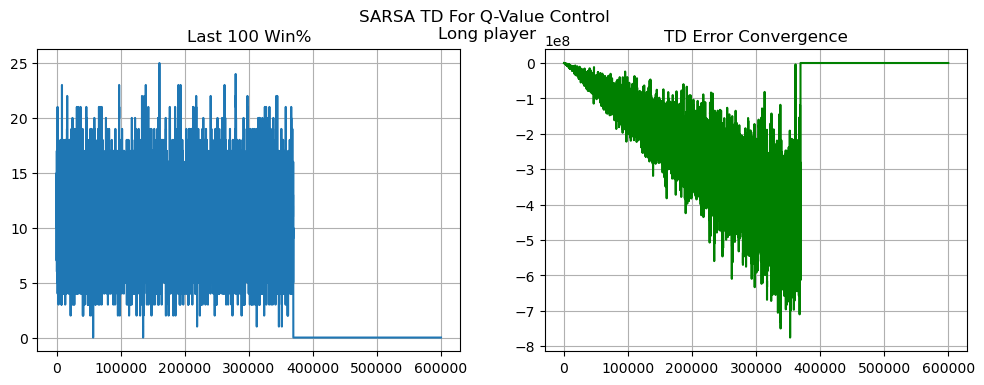

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
ax1.plot(range(100,NUM_EPISODES),trend_wins)
ax2.plot(range(100,NUM_EPISODES),trend_TD,c='g')
ax1.title.set_text("Last 100 Win%")
ax2.title.set_text("TD Error Convergence")
fig.suptitle('SARSA TD For Q-Value Control \n' +  OPP_Strat + ' player')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
ax1.grid()
ax2.grid()